<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/bullriding_msts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# for strem

In [ ]:
def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '28px'
      break
    }
  }
  '''))
get_ipython().events.register('pre_run_cell', increase_font)

# bull riding elo
lmao

In [ ]:
!pip install trueskill

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm

from trueskill import Rating, quality_1vs1, rate_1vs1

<IPython.core.display.Javascript object>

In [ ]:
def get_last_rating(id, rating_table):
  try:
    id_df = rating_table.loc[rating_table['id']==id]
    last_match = id_df['appearances'].max()
    rating = id_df.loc[id_df['appearances']==last_match, 'rating'].values[0]
  except:
    rating = Rating().mu
    last_match = 0
  return rating, last_match

<IPython.core.display.Javascript object>

In [ ]:
project_dir = "drive/My Drive/bullriding"

<IPython.core.display.Javascript object>

## data dict


### rides data

`YEAR`: year duh  
`BULL_ID`: the bull that is being ridden  
`RODEO_ID`: the rodeo  
`PERF`: performance (event)  
`CONTESTANT`: name of rider  
`RIDER_SCORE`: score of the rider based on judges  
`JUDGE_A`: one of two judges, bull score only  
`JUDGE_B`: one of two judges, bull score only  
`TIME`: duration of ride  
`GO`: ???  
`COMMENTS`: ???  
`MID`: match up ID (bull + rider; also row ID)    
`QR`:  qualified ride (1 if scored; 0 if no score)    
`IS_OUT`: is the out legit? (ride oddities, rarities like hurt in the chute, bull falling down, etc)    

### competition levels  
NFR  
AB   
BB (everything that starts with A but isn't AB)  
R (everything else)  

### bull data  
each row is a bull  
`rank`: ranking among all bulls  
`avgmark`: avg bull score  
`adjavg`: adjustment based on level  
`pavg`: PBR avg  
`bavg`: CBR avg ("B" events)  
`mounted`: attempted rides  
`rode`: qualified rides  
`vtg*`: versus the best riders  
`vsr*`: versus right-handed riders  
`vsl*`: versus left-handed riders  
`dirpref`: the estimated preferred direction the bull spins  
`dirperc`: percentage the bull spins in the preferred direction  
`power`: performances + difficulty  
`winperc`: percentage of the time they are the highest marked bull in the round  
`rawrank`: temp column based on rank   
`arank`: rank among active bulls  

## Basic trueskill loop

In [ ]:
rides = pd.read_csv(f"{project_dir}/data/rides_2015_to_present.csv")
rides['make8'] = 0
rides.loc[rides['time']==8 ,'make8'] = 1
rides['rodeo_level'] = rides['rid'].str.replace('[^a-zA-Z]', '').str.upper()
rides['rodeo_level'] = (rides['rodeo_level']
 .replace(['ABG', 'ABH','ABD','ABC', 'ABB', 'ABA',
           'AC', 'AE', 'AH','ABE', 'AN','AZ',
           'ABGC', 'AV'],
          'BB')
 .replace(['C', 'F', 'Q', 'QX', 'XQ','CF',
           'X','B', 'XT', 'O','E'],
          'R'))

rides['aid'] = rides['rid'].str.replace('[^a-zA-Z]', '').str.upper()
rides['nid'] = rides['rid'].str.replace('[^0-9]', '').str.upper().astype(int)

rides.shape

<IPython.core.display.Javascript object>

(93140, 19)

In [ ]:
guys = pd.read_csv(f"{project_dir}/data/guystats.csv")
guys.shape

<IPython.core.display.Javascript object>

(9172, 19)

In [ ]:
guys.head()

<IPython.core.display.Javascript object>

,guy,records,mounted,rode,fmounted,frode,num85,hisc,ppo,streak,winperc,bullrank,bullpower,hand,ht,wt,note,pbrid,guyid
0,Aaron Atkinson,20,18,2,0,0,1,88.0,79.500,0.00,0.000,12913,61.88,NaN,70,165,NaN,1770,1
1,Aaron Bean,14,14,1,1,0,0,70.0,70.000,0.00,0.000,10988,68.69,NaN,70,185,NaN,3854,2
2,Aaron Blendell,3,1,0,0,0,0,0.0,0.000,0.00,0.000,4142,76.80,NaN,0,0,NaN,0,3
3,Aaron Brewer,158,152,39,3,0,7,89.0,76.256,6.67,0.026,11193,55.66,L,72,145,NaN,0,4
4,Aaron Brookshire,4,4,0,0,0,0,0.0,0.000,0.00,0.000,4396,64.78,NaN,0,0,NaN,0,5


In [ ]:
bulls = pd.read_csv(f"{project_dir}/data/nickwan_bulls.csv")
bulls.shape

<IPython.core.display.Javascript object>

(3890, 16)

In [ ]:
bulls.head()

<IPython.core.display.Javascript object>

,rank,pbid,bno,bname,avgmark,mounted,rode,vtgbo,vtgrode,vslbo,vslrode,vsrbo,vsrrode,dirpref,dirperc,power
0,23,31396,32Y,SweetPro's Bruiser,22.677,133,29,74,25,43,17,50,12,left,9.0,86.53
1,36,42345,524,Cliffhanger,22.560,7,0,1,0,2,0,3,0,unknown,0.0,76.90
2,39,26210,849,Crystal Deal,22.536,46,6,13,6,13,1,17,5,right,16.0,80.48
3,47,40393,43C-,Chiseled,22.457,40,11,14,11,10,3,17,8,right,9.0,79.98
4,70,38961,F50,Wild Onion,22.371,22,1,5,1,8,1,7,0,left,11.0,75.14


random trueskill stuff

In [ ]:
ab = rides.loc[(rides['rodeo_level']=='AB') & (rides['year']==2020)].sort_values(['nid','mid'])
ab['one'] = 1
ab['n_rider_appearances'] = ab.sort_values(['nid', 'mid']).loc[:, ['guyid', 'one']].groupby(['guyid'], as_index=False).cumsum()
ab['n_bull_appearances'] = ab.sort_values(['nid', 'mid']).loc[:, ['pbid', 'one']].groupby(['pbid'], as_index=False).cumsum()
ab = ab.drop(['one'], axis=1)
ab.shape

<IPython.core.display.Javascript object>

(2346, 21)

In [ ]:
df_ratings = pd.DataFrame(columns=['id', 'appearances', 'rating', 'is_bull'])
for idx, row in tqdm(ab.iterrows(), total=ab.shape[0]):
  gid = row['guyid']
  bid = row['pbid']
  gid_rating, gid_last_match = get_last_rating(gid, df_ratings)
  bid_rating, bid_last_match = get_last_rating(bid, df_ratings)

  if row['make8']:
    gid_rating, bid_rating = rate_1vs1(Rating(gid_rating), Rating(bid_rating))
  else:
    bid_rating, gid_rating = rate_1vs1(Rating(bid_rating), Rating(gid_rating))

  gid_new_match_row = gid_last_match +1
  bid_new_match_row = bid_last_match +1

  _df = pd.DataFrame([[gid,gid_new_match_row,gid_rating.mu, 0], [bid,bid_new_match_row,bid_rating.mu, 1]], columns=['id', 'appearances', 'rating', 'is_bull'])

  df_ratings = df_ratings.append(_df)
df_ratings = df_ratings.reset_index(drop=True)
_append = pd.Series()
for id in df_ratings['id'].unique():
  _df = df_ratings.loc[df_ratings['id']==id]
  _append = _append.append(_df['rating'].sub(_df['rating'].shift().fillna(25)))
df_ratings['rating_change'] = _append

df_ratings.shape

<IPython.core.display.Javascript object>

  0%|          | 0/2346 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


(4692, 5)

In [ ]:
ab = (ab
      .merge(df_ratings.loc[:, ['id', 'appearances',
                                'rating', 'rating_change']]
             .rename(columns={'id':'guyid',
                              'appearances':'n_rider_appearances',
                              'rating':'rider_rating',
                              'rating_change':'rider_rating_change'}))
      .merge(df_ratings.loc[:, ['id', 'appearances',
                                'rating', 'rating_change']]
             .rename(columns={'id':'pbid',
                              'appearances':'n_bull_appearances',
                              'rating':'bull_rating',
                              'rating_change':'bull_rating_change'}))
      .merge(bulls.loc[:, ['pbid', 'bname']].drop_duplicates()))
for col in ['rider_rating', 'bull_rating']:
  ab[col] = ab[col].sub(ab[col].mean()).add(25).mul(4)

ab.shape

<IPython.core.display.Javascript object>

(2153, 26)

In [ ]:
ab.loc[:, ['bull_rating', 'rider_rating']].describe()

<IPython.core.display.Javascript object>

,bull_rating,rider_rating
count,2153.000000,2153.000000
mean,100.000000,100.000000
std,27.699526,32.284923
min,9.783333,20.495245
25%,79.793505,76.796704
50%,101.167464,98.578938
75%,118.477002,120.259471
max,175.378336,205.294335


In [ ]:
ab.loc[:, ['bname', 'bull_rating']].groupby(['bname'], as_index=False).max().sort_values('bull_rating', ascending=False).head(20)

<IPython.core.display.Javascript object>

,bname,bull_rating
487,The Right Stuff,175.378336
447,Smooth Operator,173.898375
227,Hostage,168.728550
238,I'm Busted,168.377678
45,Blue Crush,164.720708
253,Jive Turkey,164.139047
115,CopperPoint Swagger,164.055128
7,American Gangster,163.197173
239,I'm Legit Too,162.616561
465,Strange Cargo,162.332910


In [ ]:
ab.loc[:, ['contestant', 'rider_rating']].groupby(['contestant'], as_index=False).max().sort_values('rider_rating', ascending=False).head(20)

<IPython.core.display.Javascript object>

,contestant,rider_rating
57,Jose Vitor Leme,205.294335
62,Kaique Pacheco,201.232379
75,Marco Eguchi,189.297757
73,Lucas Divino,185.232553
30,Cooper Davis,184.578316
11,Boudreaux Campbell,174.728814
42,Ezekiel Mitchell,171.465503
84,Ramon de Lima,168.777389
77,Mason Taylor,167.769805
35,Dener Barbosa,167.191710


<IPython.core.display.Javascript object>

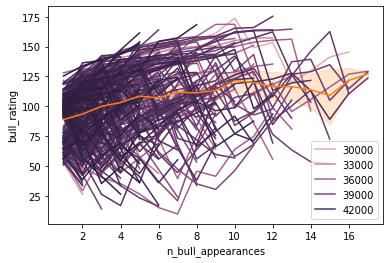

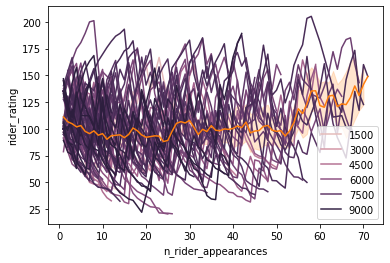

In [ ]:
sns.lineplot(data=ab, x='n_bull_appearances', y='bull_rating', hue='pbid')
sns.lineplot(data=ab, x='n_bull_appearances', y='bull_rating')
plt.show()

sns.lineplot(data=ab, x='n_rider_appearances', y='rider_rating', hue='guyid')
sns.lineplot(data=ab, x='n_rider_appearances', y='rider_rating')
plt.show()

In [ ]:
row

<IPython.core.display.Javascript object>

guyid                               6629
year                                2020
pbid                               41416
rid                                AB523
perf                                 05F
contestant             Eduardo Aparecido
sc                                     0
ja                                 22.75
jb                                 22.75
time                                2.83
go                                     F
comments                               *
mid                               453035
qr                                     0
isout                                  1
make8                                  0
rodeo_level                           AB
aid                                   AB
nid                                  523
n_rider_appearances                   51
n_bull_appearances                    12
Name: 91093, dtype: object